In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import periodogram #Used in Frequency Feature

# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV,train_test_split # Import train_test_split function


from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier,plot_tree # Import Decision Tree Classifier




In [3]:
def plot2(eegchannel, leneeg,sfreq, starttime, endtime):
    # eegchannel is the channel of EEG you wish to plot, for example F4-C4
    # leneeg is then length of the eeg file
    # sfreq is the sampling frequency
    # eegtime is the numpy array created that converts the EEG index to seconds, based on the sampling frequency
    # starttime is time in seconds of the start time of the EEG data that you wish to plot
    # endtime is the time in seconds of the end time of the EEG data that you wish to plot 
    eegst=int(sfreq*starttime) # calculate the start eeg index
    eeget=int(sfreq*endtime)# calculate the end eeg index
    eegtime= np.arange(0,leneeg,1)/sfreq 
    fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,5))
    eeg_trace = ax.plot(eegtime[eegst:eeget+1], eeg.loc[eegst:eeget,eegchannel],color='blue',label='EEG') # Plot EEG Data
    ax.set_ylabel('$\mu V$',color='blue',fontsize=16) # Set left hand yaxis label to 'Cases'.
    ax.set_xlabel('Seconds',color='green',fontsize=16) # Set left hand yaxis label to 'Cases'.
    ax2 = ax.twinx() # Create a second y axis on the right hand side of the plot using the same x axis.
    annotations = ax2.plot(channelAnno.loc[starttime:endtime,eegchannel],color='red',label='Seizure') # Plot Annotation data.
    ax2.set_ylabel('Seizure',color='red',fontsize=16) # Set right hand yaxis label to 'Deaths'.
    ax2.set_ylim(bottom=0) # Limit the right-hand y axis to start at 0.
    ax2.grid() # Plot a grid for the right hand y axis.
    ax2.legend(eeg_trace + annotations, [eegchannel,'Seizure'], fontsize=16, loc='best')
    ax.set_title('EEG and Anotation',fontsize=16) 
    plt.show

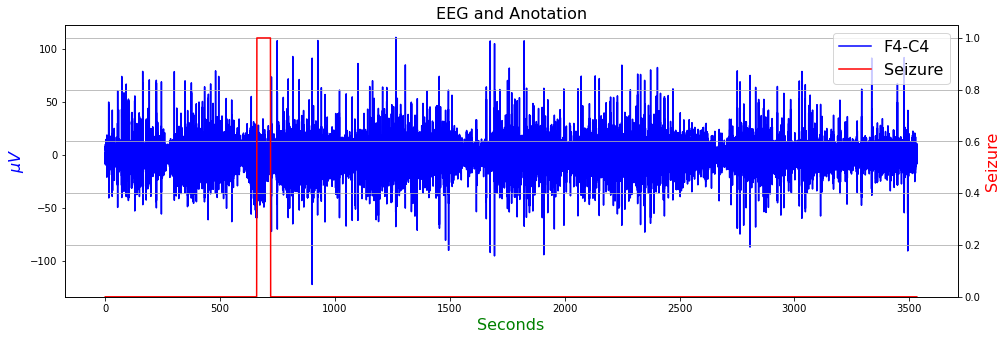

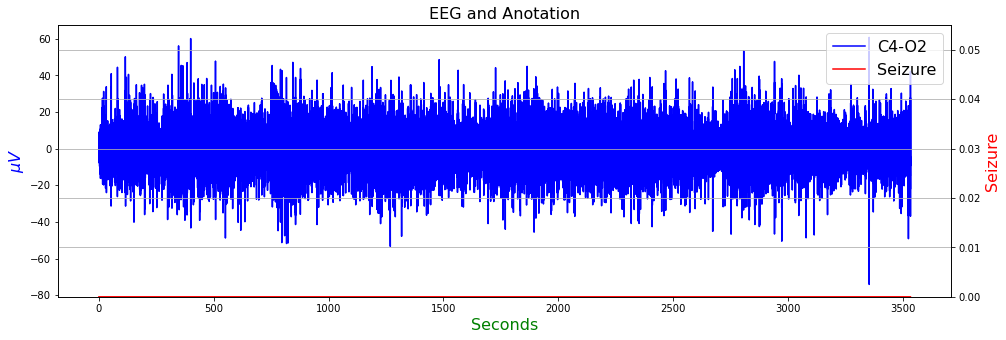

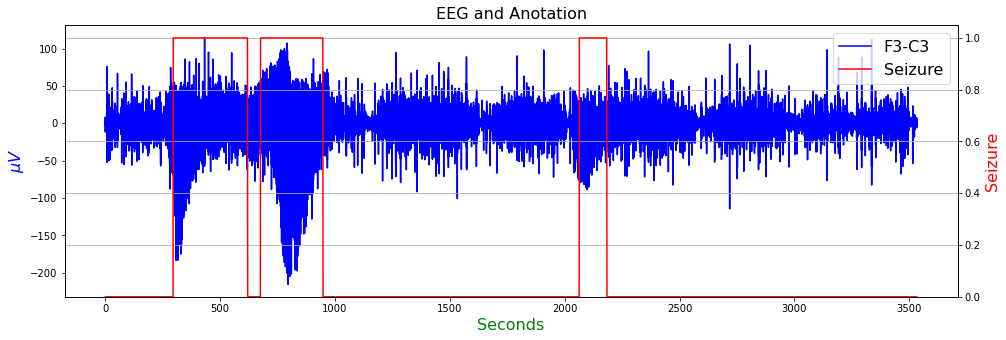

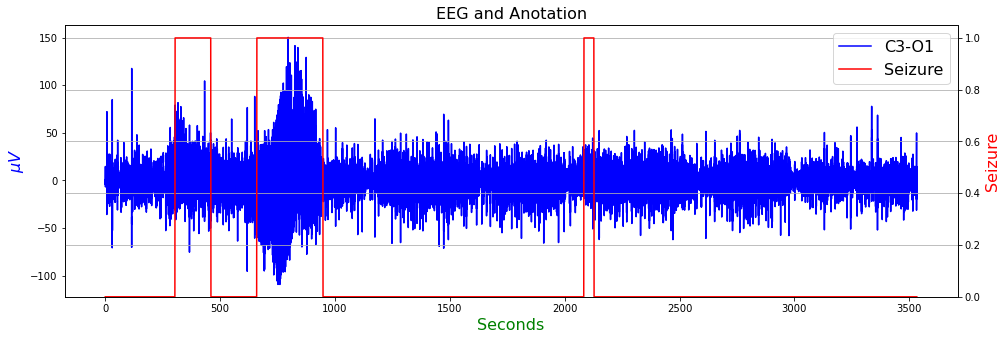

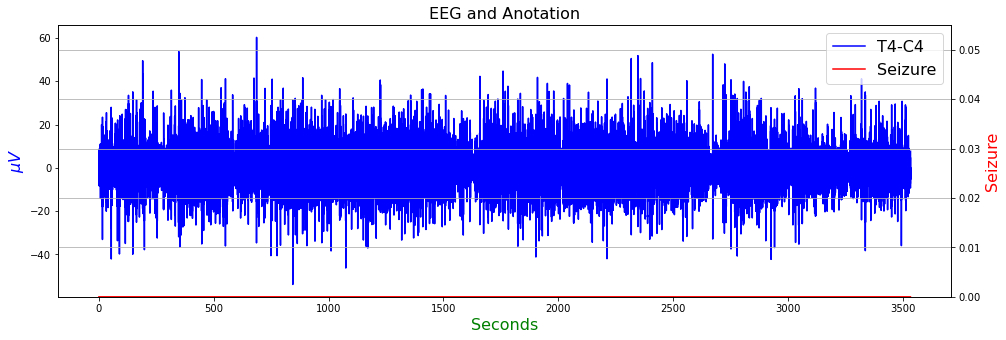

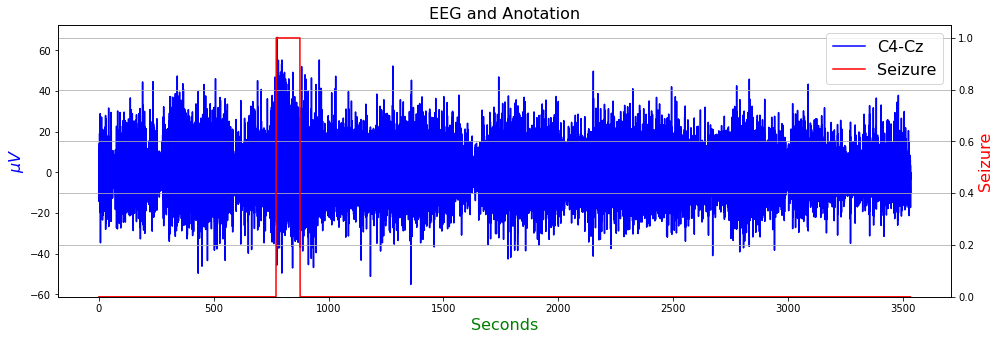

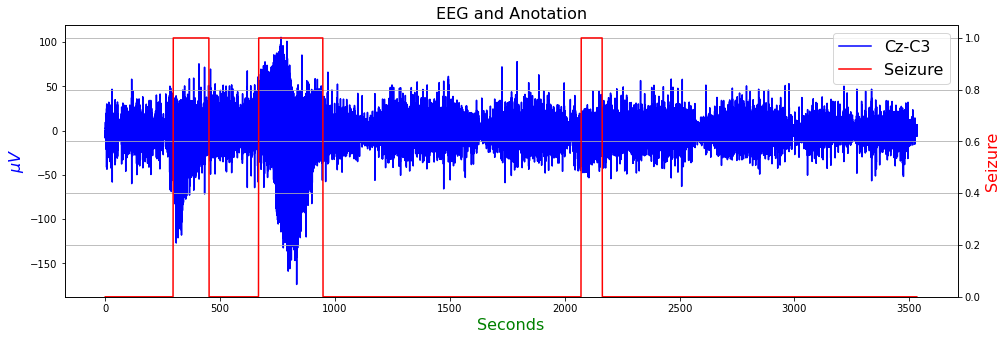

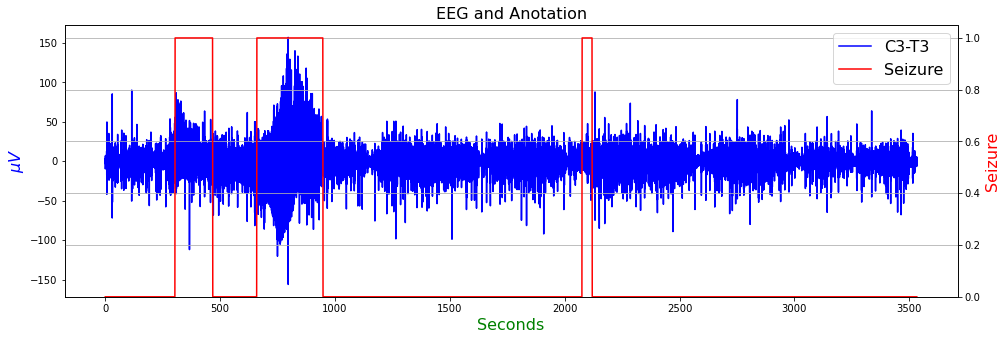

In [4]:
eeg =  pd.read_csv('EEG9_processed.csv')
channelAnno = pd.read_csv('eeg9_Combined_Exper_Annotations.csv').drop("Unnamed: 0",axis = 1)
plot2('F4-C4', len(eeg),32, 0, len(eeg)/32)
plot2('C4-O2', len(eeg),32, 0, len(eeg)/32)
plot2('F3-C3', len(eeg),32, 0, len(eeg)/32)
plot2('C3-O1', len(eeg),32, 0, len(eeg)/32)
plot2('T4-C4', len(eeg),32, 0, len(eeg)/32)
plot2('C4-Cz', len(eeg),32, 0, len(eeg)/32)
plot2('Cz-C3', len(eeg),32, 0, len(eeg)/32)
plot2('C3-T3', len(eeg),32, 0, len(eeg)/32)

In [5]:
eeg

,F4-C4,C4-O2,F3-C3,C3-O1,T4-C4,C4-Cz,Cz-C3,C3-T3
0,1.887922,-1.620295,1.047026,-4.060826,1.101734,1.650907,-0.302366,-1.380142
1,0.985949,-5.521338,-4.923230,-2.474043,5.250998,2.277279,-5.451613,-1.861027
2,1.011332,-5.883657,-5.042618,-2.175349,5.463895,1.781856,-5.766853,-1.507051
3,1.107370,-4.592668,-3.667937,-2.996473,4.663299,3.042621,-4.689177,-2.069705
4,1.425294,-6.300701,-5.902869,-1.474293,5.487804,0.827836,-5.835573,-1.848130
...,...,...,...,...,...,...,...,...
113067,10.769510,16.479184,0.106986,6.202392,-0.252663,-14.086621,0.512820,2.424597
113068,4.908637,-15.637027,-0.092107,7.124224,-4.658679,-1.995848,-1.753141,4.317196
113069,2.878931,-17.005395,0.101585,1.407520,-1.953992,-1.464896,-0.844548,2.882014
113070,4.649306,-9.398800,1.795556,-4.234313,3.009348,-2.876400,-4.340586,-0.780029


In [6]:
eeg_9 = pd.melt(eeg)
eeg_9_label_combined = pd.melt(channelAnno)
eeg_9_label_combined

,variable,value
0,F4-C4,0.0
1,F4-C4,0.0
2,F4-C4,0.0
3,F4-C4,0.0
4,F4-C4,0.0
...,...,...
28379,C3-T3,0.0
28380,C3-T3,0.0
28381,C3-T3,0.0
28382,C3-T3,0.0


# Line Length

In [7]:
def LLcalculation(N, epoch):
    LL = sum(np.absolute(epoch[i+1]-epoch[i]) for i in range(N-1))
    return LL

In [8]:
NEpoch = 256
Noverlap=128
numberofEpochs = (len(eeg_9)-NEpoch)//(NEpoch-Noverlap) + 1 # Use integer divison // to get exact number of epochs
numberofEpochs

7066

In [9]:
epochstart=0
LL_Feature_9 = np.array([])
for i in range(numberofEpochs):
    Epoch= eeg_9.loc[epochstart:epochstart+NEpoch-1,"value"].to_numpy()
    epochstart += Noverlap
    LL_Feature_9=np.append(LL_Feature_9,LLcalculation(NEpoch, Epoch))

In [10]:
len(LL_Feature_9), LL_Feature_9

(7066,
 array([597.04436369, 554.32402556, 927.70278837, ..., 444.47698824,
        441.44783395, 330.62615285]))

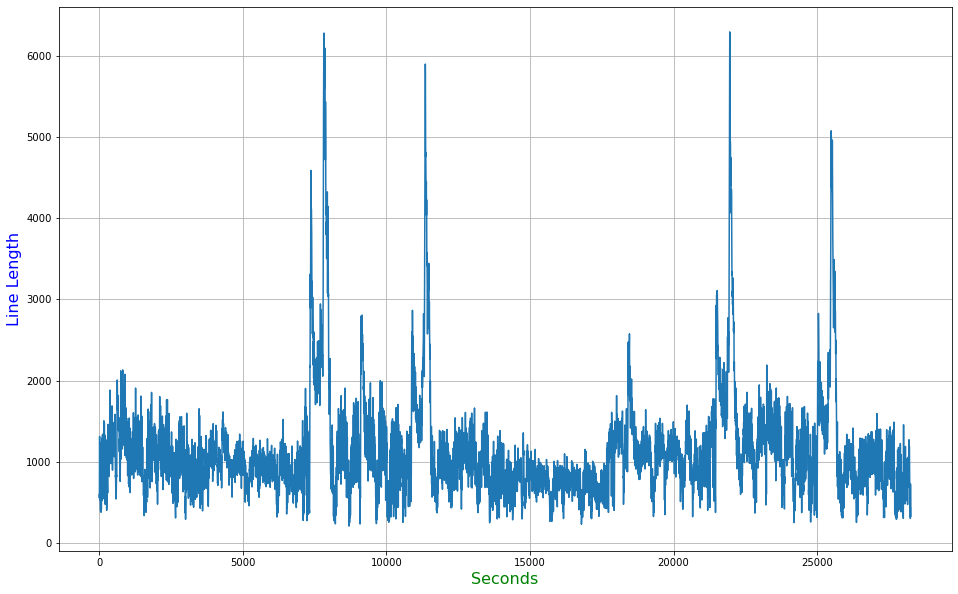

In [11]:
featuretime= np.arange(1,numberofEpochs+1,1)*4 # Converting the Feature index to seconds, ie. a new feature value is generated every 4 seconds.
plt.figure(figsize=(16,10))
plt.plot(featuretime, LL_Feature_9)
plt.ylabel('Line Length', fontsize=16, color='blue')
plt.xlabel('Seconds',color='green',fontsize=16)
plt.grid()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

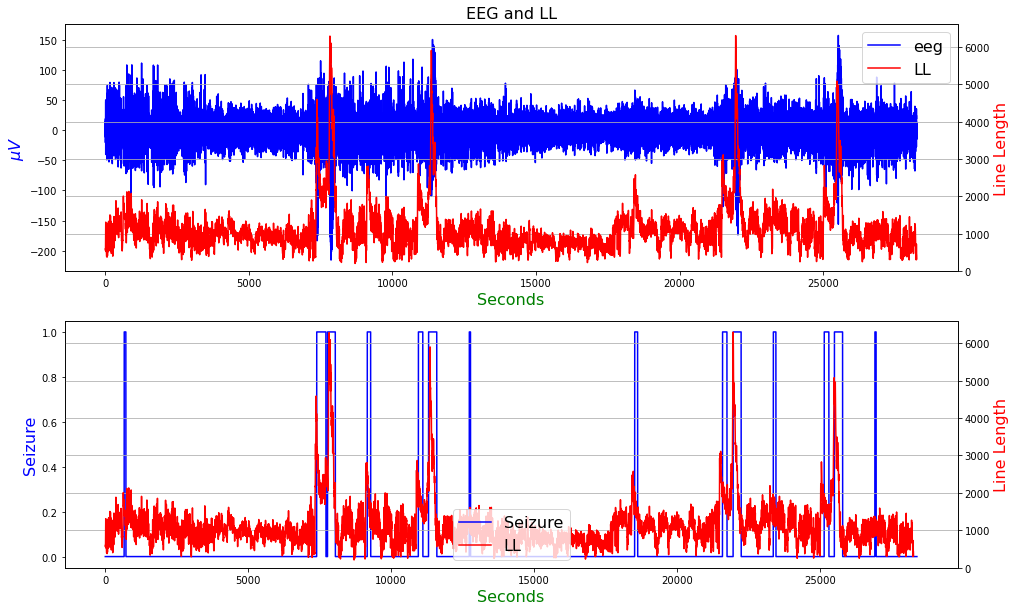

In [12]:
fig,ax = plt.subplots(nrows = 2, ncols = 1, figsize=(16,10))
recordingtime= np.arange(0,len(eeg_9),1)/32 
eeg_trace = ax[0].plot(recordingtime, eeg_9['value'],color='blue',label='eeg 9') # Plot EEG Data
ax[0].set_ylabel('$\mu V$',color='blue',fontsize=16) 
ax[0].set_xlabel('Seconds',color='green',fontsize=16) 
ax2 = ax[0].twinx() # Create a second y axis on the right hand side of the plot using the same x axis.
features = ax2.plot(featuretime, LL_Feature_9,color='red',label='LL') # Plot Annotation data.
ax2.set_ylabel('Line Length', fontsize=16, color='red') 
ax2.set_ylim(bottom=0) # Limit the right-hand y axis to start at 0.
ax2.grid() # Plot a grid for the right hand y axis.
ax2.legend(eeg_trace + features, ['eeg','LL'], fontsize=16, loc='best') 
ax[0].set_title('EEG and LL',fontsize=16) 

annotations = ax[1].plot(eeg_9_label_combined['value'],color='blue',label='Seizure') # Plot EEG Data
ax[1].set_ylabel('Seizure',color='blue',fontsize=16) 
ax[1].set_xlabel('Seconds',color='green',fontsize=16) 
ax2 = ax[1].twinx() # Create a second y axis on the right hand side of the plot using the same x axis.
features = ax2.plot(featuretime, LL_Feature_9,color='red',label='LL') # Plot Annotation data.
ax2.set_ylabel('Line Length', fontsize=16, color='red') 
ax2.set_ylim(bottom=0) # Limit the right-hand y axis to start at 0.
ax2.grid() # Plot a grid for the right hand y axis.
ax2.legend(annotations + features, ['Seizure','LL'], fontsize=16, loc='lower center')

plt.show

# Root Mean Squared Amplitude

In [18]:
def RMSAcalculation(N, epoch):
    RMSA = np.sqrt((1/N)*sum((epoch[i])**2 for i in range(N)))
    return RMSA

In [19]:
epochstart=0
RMSA_Feature_9 = np.array([])
for i in range(numberofEpochs):
    Epoch= eeg_9.loc[epochstart:epochstart+NEpoch-1,"value"].to_numpy()
    epochstart += Noverlap
    RMSA_Feature_9=np.append(RMSA_Feature_9,RMSAcalculation(NEpoch, Epoch))

In [20]:
len(RMSA_Feature_9), RMSA_Feature_9

(7066,
 array([ 5.55717558,  5.87527913, 11.17983839, ...,  5.14776939,
         5.07915453,  2.61647091]))

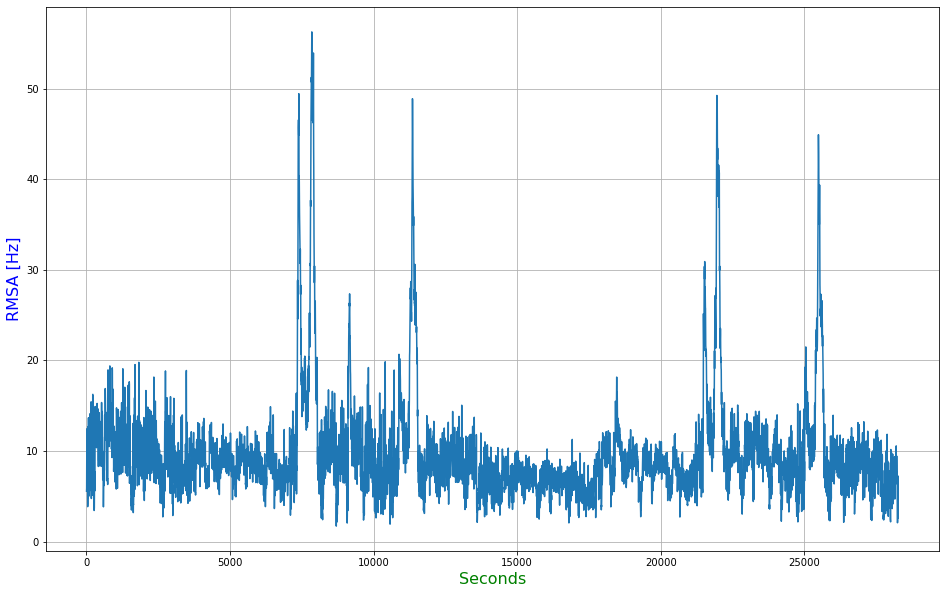

In [21]:
featuretime= np.arange(1,numberofEpochs+1,1)*4 # Converting the Feature index to seconds, ie. a new feature value is generated every 4 seconds.
plt.figure(figsize=(16,10))
plt.plot(featuretime, RMSA_Feature_9)
plt.ylabel('RMSA [Hz]', fontsize=16, color='blue')
plt.xlabel('Seconds',color='green',fontsize=16)
plt.grid()
plt.show()

# Non Linear Energy

In [22]:
def NLEcalculation(N, epoch):
    NLE = (1/(N-2))*sum(((epoch[i+1])**2 - epoch[i]*epoch[i+2]) for i in range(N-2))
    return NLE

In [23]:
epochstart=0
NLE_Feature_9 = np.array([])
for i in range(numberofEpochs):
    Epoch= eeg_9.loc[epochstart:epochstart+NEpoch-1,"value"].to_numpy()
    epochstart += Noverlap
    NLE_Feature_9=np.append(NLE_Feature_9,NLEcalculation(NEpoch, Epoch))

In [24]:
len(NLE_Feature_9), NLE_Feature_9

(7066,
 array([15.85590246, 13.40796924, 66.3169418 , ...,  7.45286525,
         7.33998173,  3.00540359]))

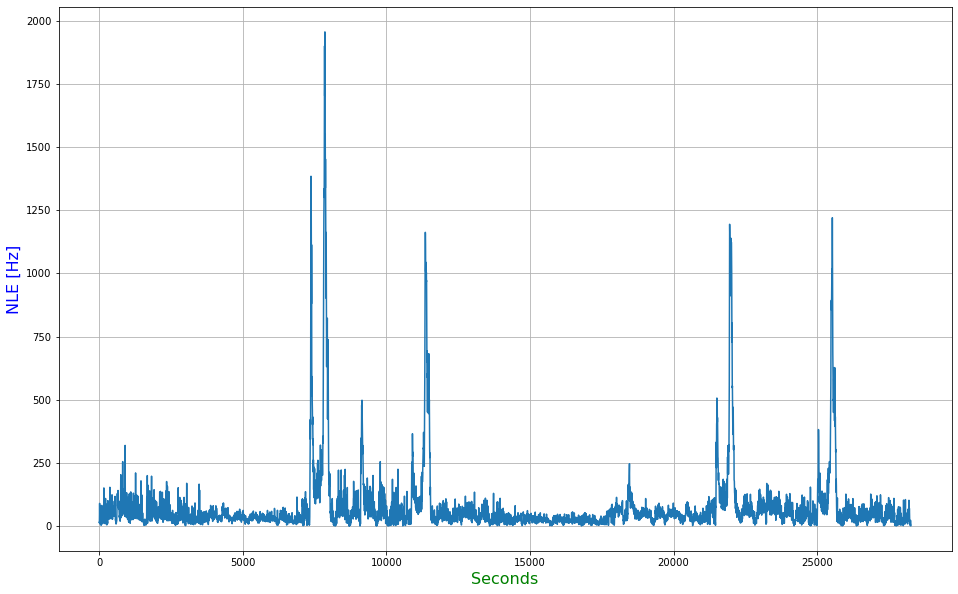

In [25]:
featuretime= np.arange(1,numberofEpochs+1,1)*4 # Converting the Feature index to seconds, ie. a new feature value is generated every 4 seconds.
plt.figure(figsize=(16,10))
plt.plot(featuretime, NLE_Feature_9)
plt.ylabel('NLE [Hz]', fontsize=16, color='blue')
plt.xlabel('Seconds',color='green',fontsize=16)
plt.grid()
plt.show()

# 1st Hjorth Parameter: Activity

In [51]:
def Meancalculation(N, epoch):
    Mean = (1/N)*sum((epoch[i]) for i in range(N))
    return Mean

In [177]:
def Activitycalculation(N, epoch):
    Mean = Meancalculation(N, epoch)
    Activity = (1/N)*(sum(((epoch[i] - Mean)**2) for i in range(N)))
    return Activity

In [178]:
epochstart=0
Activity_Feature_9 = np.array([])
for i in range(numberofEpochs):
    Epoch= eeg_9.loc[epochstart:epochstart+NEpoch-1,"value"].to_numpy()
    epochstart += Noverlap
    Activity_Feature_9=np.append(Activity_Feature_9,Activitycalculation(NEpoch, Epoch))

In [194]:
len(Activity_Feature_9), Activity_Feature_9

(7066, 2.893561093486894)

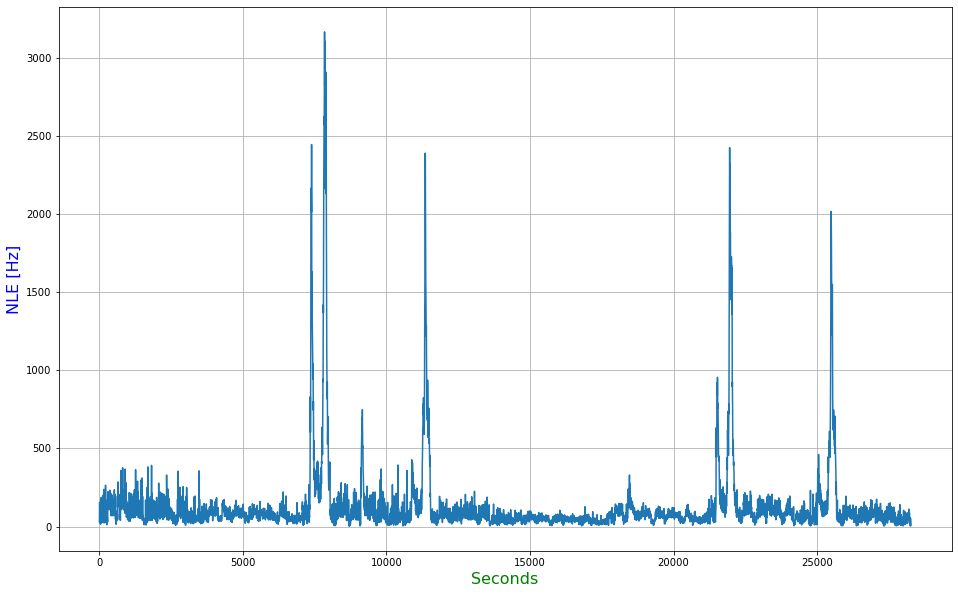

In [180]:
featuretime= np.arange(1,numberofEpochs+1,1)*4 # Converting the Feature index to seconds, ie. a new feature value is generated every 4 seconds.
plt.figure(figsize=(16,10))
plt.plot(featuretime, Activity_Feature_9)
plt.ylabel('NLE [Hz]', fontsize=16, color='blue')
plt.xlabel('Seconds',color='green',fontsize=16)
plt.grid()
plt.show()

# 2nd Hjorth Parameter: Mobility

## Mean

In [290]:
def MeanFirstDeriv(N, epoch):
    Mean = (1/(N-1))*sum((epoch[i+1]-epoch[i]) for i in range(N-1))
    return Mean

In [291]:
def VarFirstDeriv(N,epoch):
    Mean = MeanFirstDeriv(N, epoch)
    Var = (1/(N-1))*sum(((epoch[i+1]- epoch[i])- Mean)**2 for i in range(N-1))
    return Var

In [293]:
def Mobilitycalculation(N, epoch):
    Var = VarFirstDeriv(N, epoch)
    Activity = Activitycalculation(N,epoch)
    Mobility = np.sqrt(Var/Activity)
    return Mobility

In [294]:
epochstart=0
Mobility_Feature_9 = np.array([])
for i in range(numberofEpochs):
    Epoch= eeg_9.loc[epochstart:epochstart+NEpoch-1,"value"].to_numpy()
    epochstart += Noverlap
    Mobility_Feature_9=np.append(Mobility_Feature_9, Mobilitycalculation(NEpoch, Epoch))

In [295]:
len(Mobility_Feature_9), Mobility_Feature_9

(7066,
 array([0.59689009, 0.52389577, 0.62483225, ..., 0.47942788, 0.48603205,
        0.66422151]))

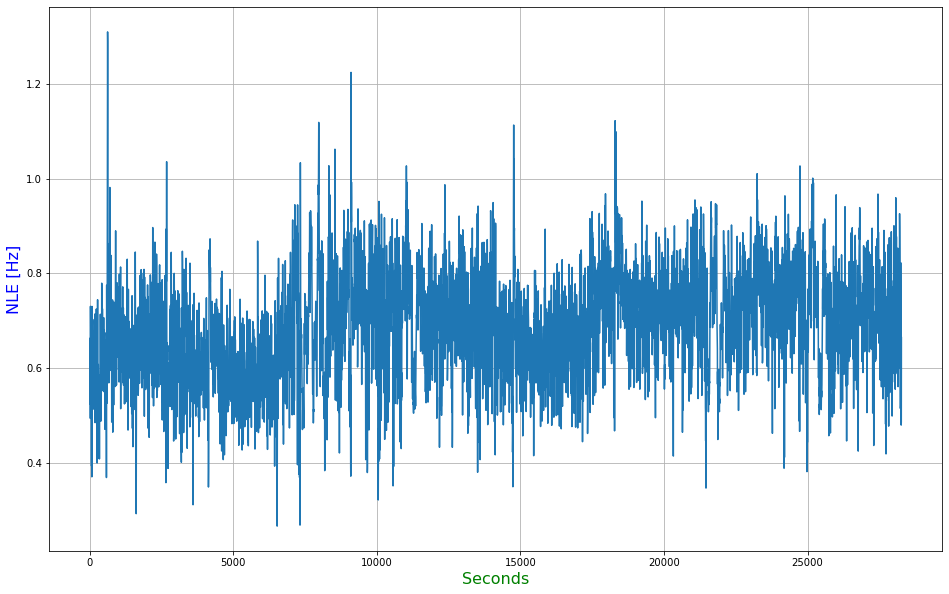

In [296]:
featuretime= np.arange(1,numberofEpochs+1,1)*4 # Converting the Feature index to seconds, ie. a new feature value is generated every 4 seconds.
plt.figure(figsize=(16,10))
plt.plot(featuretime, Mobility_Feature_9)
plt.ylabel('NLE [Hz]', fontsize=16, color='blue')
plt.xlabel('Seconds',color='green',fontsize=16)
plt.grid()
plt.show()

# 3rd Hjorth Parameter: Complexity

In [297]:
def MeanSecondDeriv(N, epoch):
    Mean = (1/N-2)*sum(((epoch[i+2] - epoch[i+1])-(epoch[i+1] - epoch[i])) for i in range(N-2))
    return Mean

In [299]:
def VarSecondDeriv(N,epoch):
    Mean = MeanSecondDeriv(N, epoch)
    Var = (1/(N-2))*sum((((epoch[i+2] - epoch[i+1])-(epoch[i+1] - epoch[i]))- Mean)**2 for i in range(N-2))
    return Var

In [300]:
def Complexitycalculation(N, epoch):
    Var = VarSecondDeriv(N, epoch)
    Activity = Activitycalculation(N,epoch)
    Complexity = np.sqrt(Var/Activity)
    return Complexity

In [301]:
epochstart=0
Complexity_Feature_9 = np.array([])
for i in range(numberofEpochs):
    Epoch= eeg_9.loc[epochstart:epochstart+NEpoch-1,"value"].to_numpy()
    epochstart += Noverlap
    Complexity_Feature_9=np.append(Complexity_Feature_9, Complexitycalculation(NEpoch, Epoch))

In [302]:
len(Complexity_Feature_9), Complexity_Feature_9

(7066,
 array([1.44963618, 0.97530074, 1.8752195 , ..., 0.63784904, 0.70662779,
        2.95070867]))

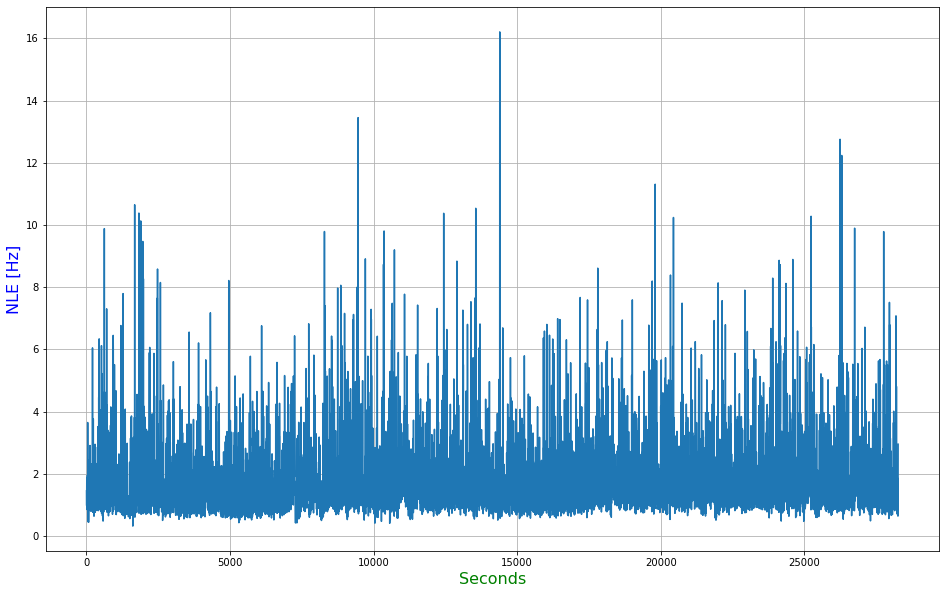

In [303]:
featuretime= np.arange(1,numberofEpochs+1,1)*4 # Converting the Feature index to seconds, ie. a new feature value is generated every 4 seconds.
plt.figure(figsize=(16,10))
plt.plot(featuretime, Complexity_Feature_9)
plt.ylabel('NLE [Hz]', fontsize=16, color='blue')
plt.xlabel('Seconds',color='green',fontsize=16)
plt.grid()
plt.show()

# Intensity Weighted Mean Frequency (IWMF)

In [13]:
def fmcalculation(psd, fs, N):
    df = fs/N # fs is the sampling freaquency = 32Hz
    num = df * sum(psd[i]*i for i in range((N//2)-1))
    den = sum(psd[i] for i in range((N//2)-1))
    return num/den

In [14]:
epochstart=0
FM_Feature = np.array([])
for i in range(numberofEpochs):
    Epoch= eeg_9.loc[epochstart:epochstart+NEpoch-1,'value'].to_numpy()
    PSD = periodogram(Epoch,fs=32,window='hann',detrend=False)[1]
    epochstart += Noverlap
    FM_Feature=np.append(FM_Feature,fmcalculation(PSD, 32, NEpoch))

In [333]:
FM_Feature,len(FM_Feature)

(array([2.42490052, 2.37179795, 1.63597013, ..., 1.37733134, 2.28863959,
        2.1323311 ]),
 7066)

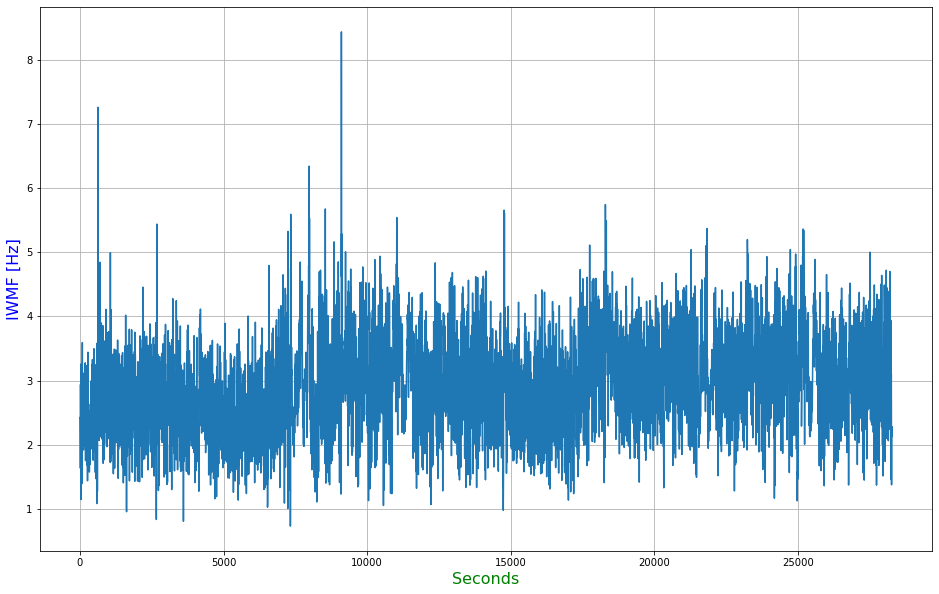

In [17]:
featuretime= np.arange(1,numberofEpochs+1,1)*4 # Converting the Feature index to seconds, ie. a new feature value is generated every 4 seconds.
plt.figure(figsize=(16,10))
plt.plot(featuretime, FM_Feature)
plt.ylabel('IWMF [Hz]', fontsize=16, color='blue')
plt.xlabel('Seconds',color='green',fontsize=16)
plt.grid()
plt.show()

# Intensity Weighted Bandwidth

In [331]:
def bwcalculation(psd, fs, N):
    fm = fmcalculation(psd, fs, N)
    df = fs/N # fs is the sampling freaquency = 32Hz   
    num = sum(psd[i]*((fm - i*df)**2) for i in range((N//2)-1))
    den = sum(psd[i] for i in range((N//2)-1))
    return np.sqrt(num/den)

In [332]:
epochstart=0
BW_Feature = np.array([])
for i in range(numberofEpochs):
    Epoch= eeg_9.loc[epochstart:epochstart+NEpoch-1,'value'].to_numpy()
    PSD = periodogram(Epoch,fs=32,window='hann',detrend=False)[1]
    epochstart += Noverlap
    BW_Feature=np.append(BW_Feature,bwcalculation(PSD, 32, NEpoch))

In [334]:
BW_Feature,len(BW_Feature)

(array([1.87097948, 1.89392134, 1.90416491, ..., 1.69894156, 2.63127797,
        2.63284017]),
 7066)

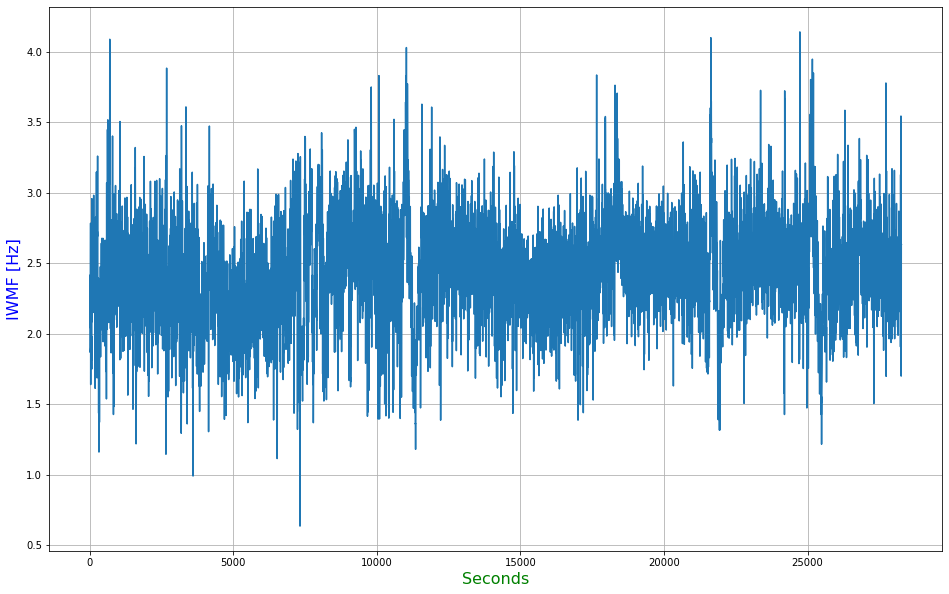

In [336]:
featuretime= np.arange(1,numberofEpochs+1,1)*4 # Converting the Feature index to seconds, ie. a new feature value is generated every 4 seconds.
plt.figure(figsize=(16,10))
plt.plot(featuretime, BW_Feature)
plt.ylabel('IWMF [Hz]', fontsize=16, color='blue')
plt.xlabel('Seconds',color='green',fontsize=16)
plt.grid()
plt.show()

# Total Power

In [365]:
def tpcalculation(psd, N):
    tp = sum(psd[i] for i in range((N//2)-1))
    return tp

In [366]:
epochstart=0
TP_Feature = np.array([])
for i in range(numberofEpochs):
    Epoch= eeg_9.loc[epochstart:epochstart+NEpoch-1,'value'].to_numpy()
    PSD = periodogram(Epoch,fs=32,window='hann',detrend=False)[1]
    epochstart += Noverlap
    TP_Feature=np.append(TP_Feature,tpcalculation(PSD,  NEpoch))

In [367]:
TP_Feature,len(TP_Feature)

(array([129.20565725, 358.94551724, 275.79731322, ..., 209.84165423,
        173.83710452,  51.74521761]),
 7066)

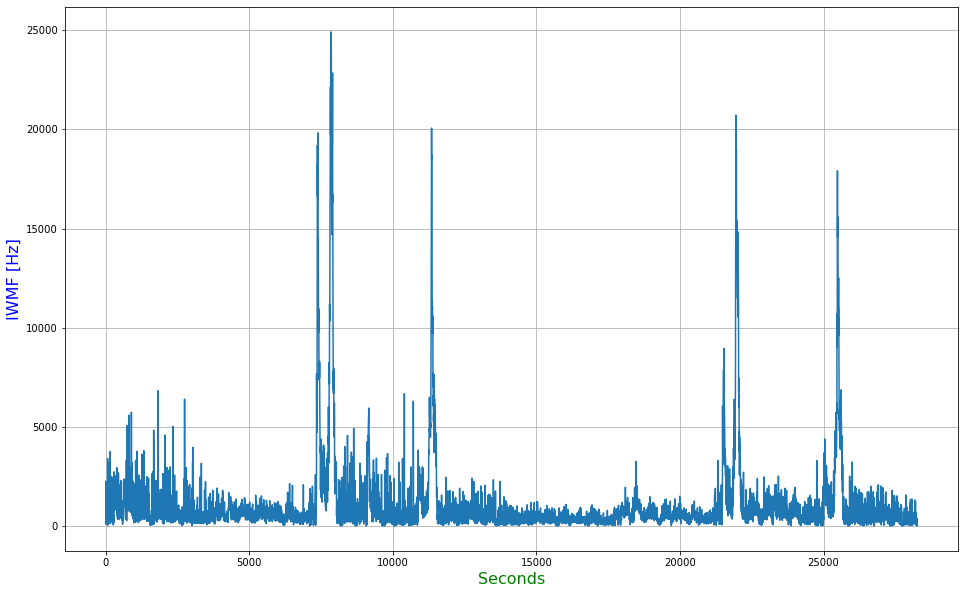

In [368]:
featuretime= np.arange(1,numberofEpochs+1,1)*4 # Converting the Feature index to seconds, ie. a new feature value is generated every 4 seconds.
plt.figure(figsize=(16,10))
plt.plot(featuretime, TP_Feature)
plt.ylabel('IWMF [Hz]', fontsize=16, color='blue')
plt.xlabel('Seconds',color='green',fontsize=16)
plt.grid()
plt.show()

# Peak Frequency

In [398]:
def pfcalculation(psd, fs, N):
    k=0
    max = psd[0]
    for i in range(1,128):
        if (psd[i] > max):
            k = i
            max = psd[i]
    return k * (fs/N)

In [405]:
epochstart=0
PF_Feature = np.array([])
for i in range(numberofEpochs):
    Epoch= eeg_9.loc[epochstart:epochstart+NEpoch-1,'value'].to_numpy()
    PSD = periodogram(Epoch,fs=32,window='hann',detrend=False)[1]
    epochstart += Noverlap
    PF_Feature=np.append(PF_Feature,pfcalculation(PSD, 32, NEpoch))

In [406]:
PF_Feature,len(PF_Feature)

(array([1.   , 0.5  , 0.625, ..., 0.625, 0.625, 0.625]), 7066)

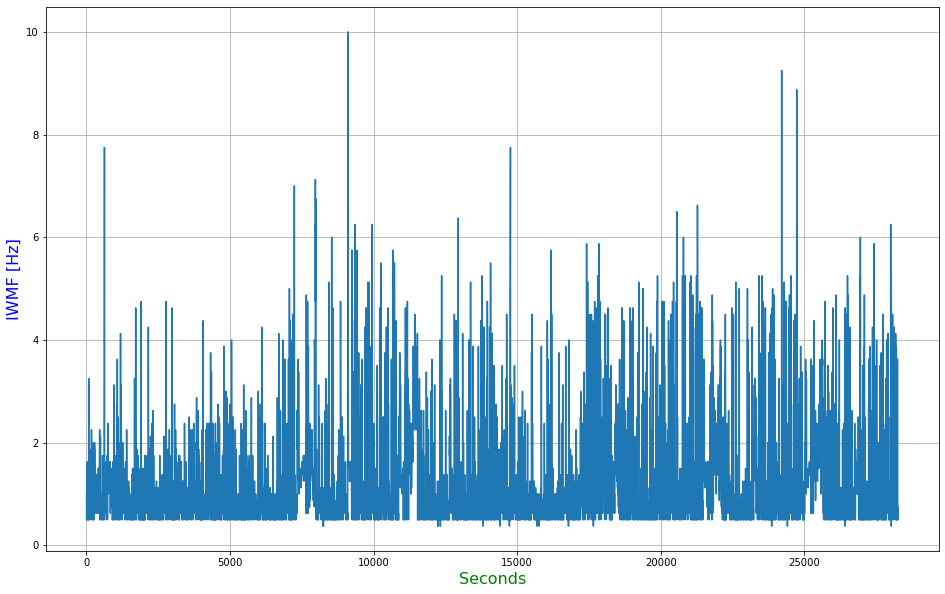

In [407]:
featuretime= np.arange(1,numberofEpochs+1,1)*4 # Converting the Feature index to seconds, ie. a new feature value is generated every 4 seconds.
plt.figure(figsize=(16,10))
plt.plot(featuretime, PF_Feature)
plt.ylabel('IWMF [Hz]', fontsize=16, color='blue')
plt.xlabel('Seconds',color='green',fontsize=16)
plt.grid()
plt.show()

# Spectral Edge Frequency

In [498]:
def SEF90calculation(psd, fs, N):
    tp = tpcalculation(psd, N)
    sef90 = 0
    i = 0
    while(sef90< 0.9*tp):
        sef90+= psd[i]
        i+=1
    sef90 = (i-1)*(fs/N)
    return sef90

In [499]:
epochstart=0
SEF90_Feature = np.array([])
for i in range(numberofEpochs):
    Epoch= eeg_9.loc[epochstart:epochstart+NEpoch-1,'value'].to_numpy()
    PSD = periodogram(Epoch,fs=32,window='hann',detrend=False)[1]
    epochstart += Noverlap
    SEF90_Feature=np.append(SEF90_Feature,SEF90calculation(PSD, 32, NEpoch))

In [500]:
SEF90_Feature,len(SEF90_Feature)

(array([5.   , 5.125, 4.25 , ..., 3.375, 6.   , 5.375]), 7066)

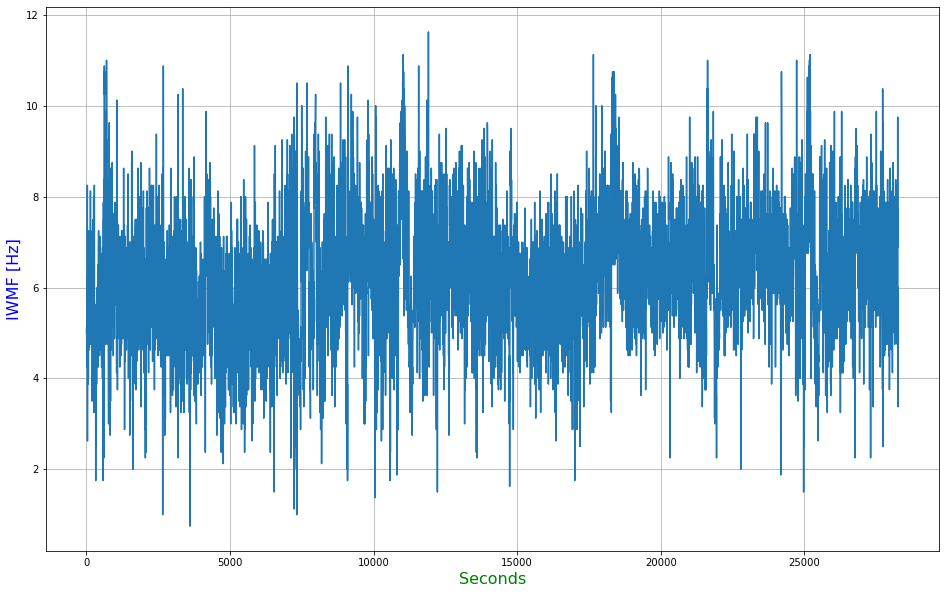

In [501]:
featuretime= np.arange(1,numberofEpochs+1,1)*4 # Converting the Feature index to seconds, ie. a new feature value is generated every 4 seconds.
plt.figure(figsize=(16,10))
plt.plot(featuretime, SEF90_Feature)
plt.ylabel('IWMF [Hz]', fontsize=16, color='blue')
plt.xlabel('Seconds',color='green',fontsize=16)
plt.grid()
plt.show()

# Model Creation

In [502]:
features = np.column_stack((LL_Feature_9,RMSA_Feature_9,NLE_Feature_9,Activity_Feature_9, Mobility_Feature_9,
                           Complexity_Feature_9,FM_Feature, BW_Feature,TP_Feature, PF_Feature, SEF90_Feature))

In [472]:
np.shape(features)

(7066, 11)

In [473]:
eeg_9_label = eeg_9_label_combined.loc[:,"value"][featuretime].to_numpy()

In [474]:
X_train, X_test, y_train, y_test = train_test_split(features, eeg_9_label, test_size=0.3, random_state=1) # 70% training and 30% test


In [475]:
np.shape(X_train), len(X_test), len(y_train), len(y_test)

((4946, 11), 2120, 4946, 2120)

In [476]:
np.count_nonzero(y_train )

436

# Decision Tree

In [477]:
param_grid = {
    'max_depth': range(1,10)
   
}

dt = DecisionTreeClassifier()

# Use grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(dt,param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy
print("Best hyperparameters: ", grid_search.best_params_)
print("Best accuracy: {:.2f}".format(grid_search.best_score_))

# Evaluate the model on the test set
accuracy = grid_search.score(X_test, y_test)
print("Test set accuracy: {:.2f}".format(accuracy))

Best hyperparameters:  {'max_depth': 5}
Best accuracy: 0.93
Test set accuracy: 0.94


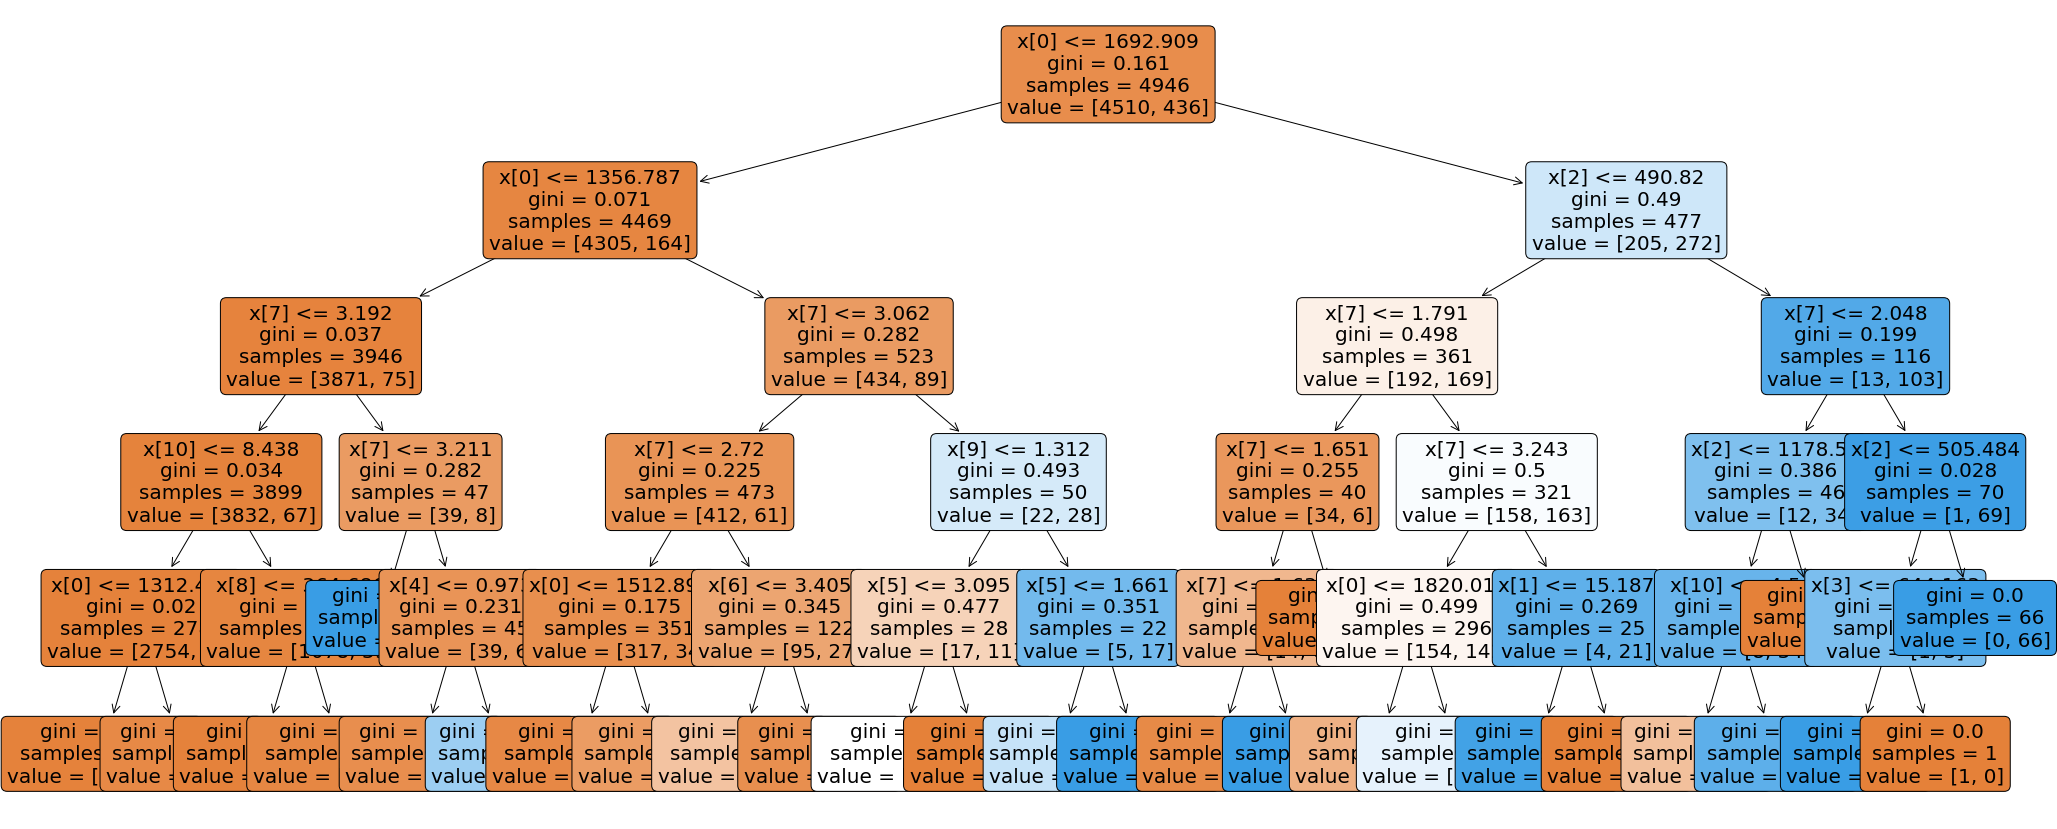

In [478]:
# Fit decision tree with optimal hyperparameters
dt_best = DecisionTreeClassifier(max_depth=grid_search.best_params_['max_depth'])
dt_best.fit(X_train, y_train)
# Plot the decision tree
plt.figure(figsize=(35, 15))
plot_tree(dt_best, filled=True, rounded=True, fontsize=20)
plt.show()

# Random Forest

In [479]:
param_grid = {
    'n_estimators': [10,50,100],
    'max_depth': range(1,8)
   
}

rf = RandomForestClassifier()

# Use grid search cross-validation to find the best hyperparameters
grid_search_2 = GridSearchCV(rf,param_grid, cv=5)
grid_search_2.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy
print("Best hyperparameters: ", grid_search_2.best_params_)
print("Best accuracy: {:.2f}".format(grid_search_2.best_score_))

Best hyperparameters:  {'max_depth': 7, 'n_estimators': 50}
Best accuracy: 0.94


In [480]:
# Initialize a new instance of RandomForestClassifier with the best hyperparameters
best_n_estimators = grid_search_2.best_params_['n_estimators']
best_max_depth = grid_search_2.best_params_['max_depth']
rf_best = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth)

# Fit the model on the training data
rf_best.fit(X_train, y_train)

# Evaluate the model on the test set
accuracy = rf_best.score(X_test, y_test)
print("Test set accuracy: {:.2f}".format(accuracy))

Test set accuracy: 0.95


In [481]:
pred = rf_best.predict(X_test)

In [482]:
sum(pred)

108.0

In [483]:
table = confusion_matrix(pred, y_test)
table

array([[1935,   77],
       [  23,   85]], dtype=int64)

In [484]:
rf_best.feature_importances_

array([0.30193052, 0.0951709 , 0.14472707, 0.10885636, 0.03906221,
       0.03205515, 0.03621347, 0.07379046, 0.0780822 , 0.03395901,
       0.05615266])

In [485]:
# Extract values from the confusion matrix
tn, fp, fn, tp = table.ravel()

# Calculate specificity and sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("Specificity: {:.2f}".format(specificity))
print("Sensitivity: {:.2f}".format(sensitivity))

Specificity: 0.96
Sensitivity: 0.79


Model performs poorly at recognising epcohs with seizures

This is due to class imbalance

Perform undersampling to make both classes have equal samples

In [486]:
from imblearn.under_sampling import RandomUnderSampler

# Create the undersampler object
undersampler = RandomUnderSampler(random_state=42)

# Fit and transform the training data
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

In [487]:
len(X_train_resampled), len(y_train_resampled), np.shape(X_train_resampled)

(872, 872, (872, 11))

In [488]:
np.count_nonzero(y_train_resampled)

436

# Decision Tree on Resampled Data

In [489]:
param_grid = {
    'max_depth': range(1,10)
   
}

dt = DecisionTreeClassifier()

# Use grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(dt,param_grid, cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best hyperparameters and the corresponding accuracy
print("Best hyperparameters: ", grid_search.best_params_)
print("Best accuracy: {:.2f}".format(grid_search.best_score_))

# Evaluate the model on the test set
accuracy = grid_search.score(X_test, y_test)
print("Test set accuracy: {:.2f}".format(accuracy))

Best hyperparameters:  {'max_depth': 1}
Best accuracy: 0.84
Test set accuracy: 0.88


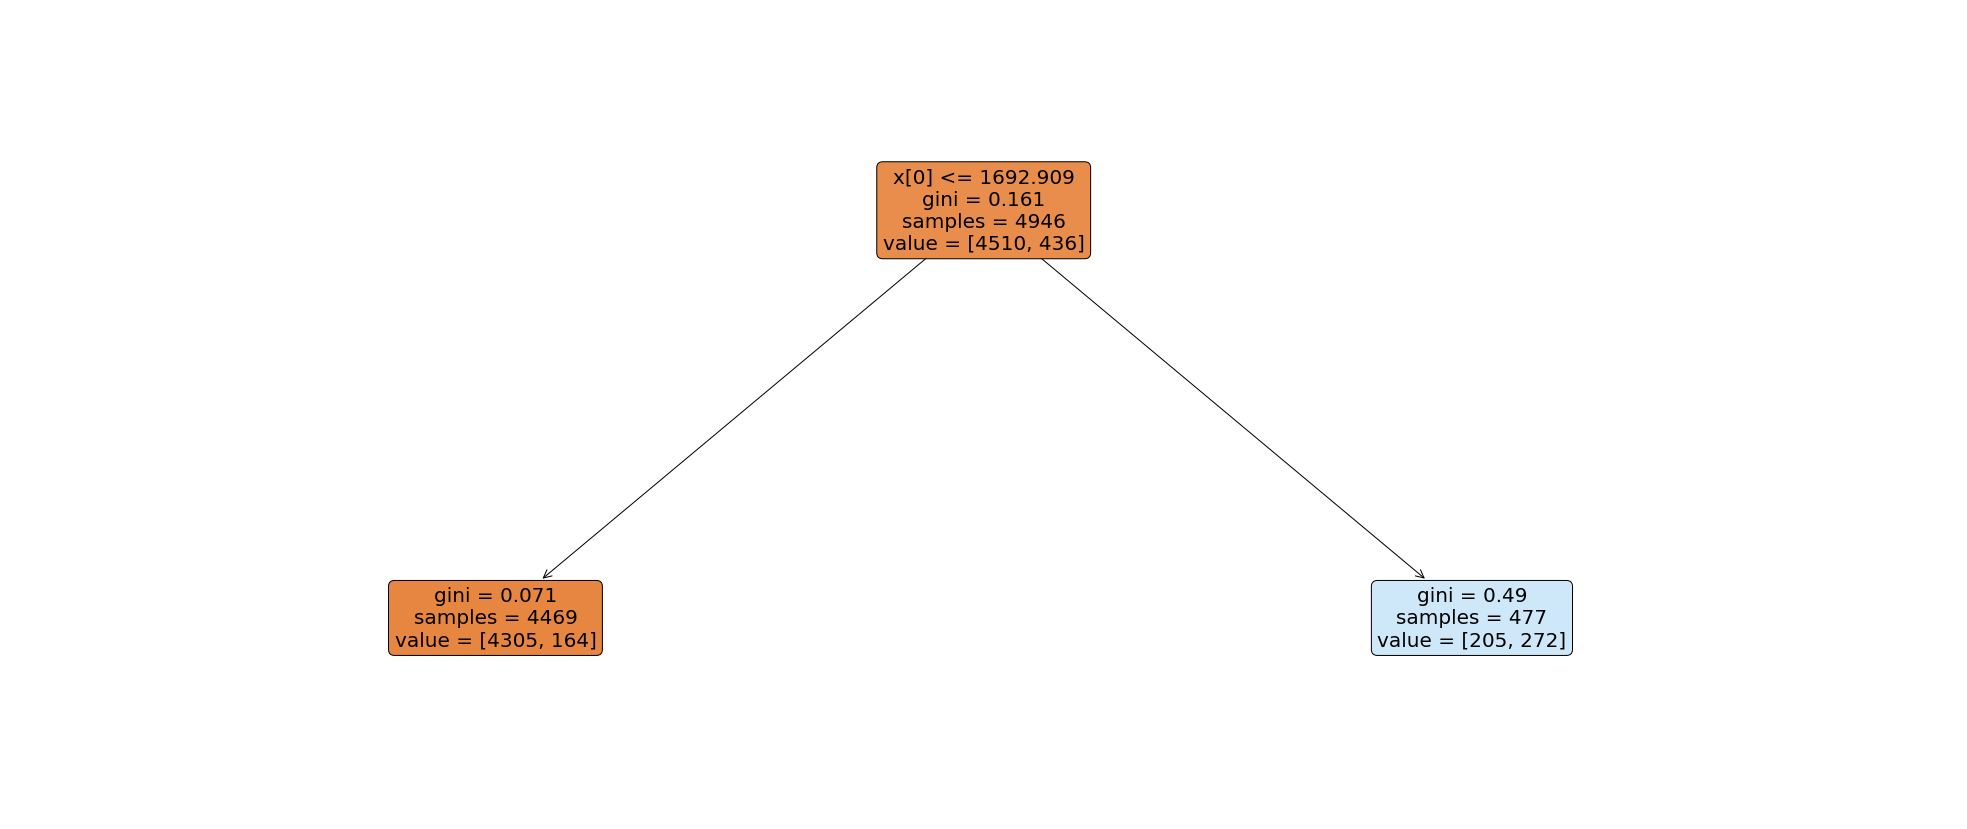

In [490]:
# Fit decision tree with optimal hyperparameters
dt_best = DecisionTreeClassifier(max_depth=grid_search.best_params_['max_depth'])
dt_best.fit(X_train, y_train)
# Plot the decision tree
plt.figure(figsize=(35, 15))
plot_tree(dt_best, filled=True, rounded=True, fontsize=20)
plt.show()

In [491]:
pred = dt_best.predict(X_test )

table = confusion_matrix(y_true = y_test,y_pred = pred)
print(table)

# Extract values from the confusion matrix
tn, fp, fn, tp = table.ravel()

# Calculate specificity and sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("Specificity: {:.2f}".format(specificity))
print("Sensitivity: {:.2f}".format(sensitivity))

[[1879   79]
 [  54  108]]
Specificity: 0.96
Sensitivity: 0.67


# RF on Resampled data

In [492]:
param_grid = {
    'n_estimators': [10,50,100],
    'max_depth': range(1,8)
   
}

rf = RandomForestClassifier()

# Use grid search cross-validation to find the best hyperparameters
grid_search_2 = GridSearchCV(rf,param_grid, cv=5)
grid_search_2.fit(X_train_resampled, y_train_resampled)

# Print the best hyperparameters and the corresponding accuracy
print("Best hyperparameters: ", grid_search_2.best_params_)
print("Best accuracy: {:.2f}".format(grid_search_2.best_score_))

Best hyperparameters:  {'max_depth': 5, 'n_estimators': 10}
Best accuracy: 0.85


In [493]:
# Initialize a new instance of RandomForestClassifier with the best hyperparameters
best_n_estimators = grid_search_2.best_params_['n_estimators']
best_max_depth = grid_search_2.best_params_['max_depth']
rf_best = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth)

# Fit the model on the training data
rf_best.fit(X_train_resampled, y_train_resampled)

# Evaluate the model on the test set
accuracy = rf_best.score(X_test, y_test)
print("Test set accuracy: {:.2f}".format(accuracy))

Test set accuracy: 0.86


In [494]:
pred_test = rf_best.predict(X_train_resampled)
table = confusion_matrix(y_true = y_train_resampled,y_pred = pred_test)
table

array([[393,  43],
       [ 62, 374]], dtype=int64)

In [495]:
pred = rf_best.predict(X_test )

table = confusion_matrix(y_true = y_test,y_pred = pred)
print(table)

# Extract values from the confusion matrix
tn, fp, fn, tp = table.ravel()

# Calculate specificity and sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("Specificity: {:.2f}".format(specificity))
print("Sensitivity: {:.2f}".format(sensitivity))

[[1692  266]
 [  25  137]]
Specificity: 0.86
Sensitivity: 0.85


In [497]:
rf_best.feature_importances_

array([0.42654366, 0.07399484, 0.25214979, 0.02358328, 0.03759325,
       0.02111402, 0.02263591, 0.0494744 , 0.02999472, 0.0143555 ,
       0.04856063])